In [ ]:
import json
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [ ]:
# General definitions
rootdir = ".."
data_directory = os.path.join(rootdir, "hpob")
search_space_id = "4796"
part = "test"

In [ ]:
# Approach definitions
num_particles = 10
num_random_trajectories = 100
horizon = 3
optimizer="sgd"
lr = 0.001
mpc_seed = 5

In [ ]:
# get part files
with open(os.path.join(data_directory, "splits", f"{part}.json"), "r") as f:
    files = json.load(f)[search_space_id]

In [93]:
# initialize search space results
search_space_results = []
search_space_results_rank = []

col_names = None
# get individual task names
for task in files:

    # approach_results = dict()
    # variant_name = "{pre_trained} {apply_lookahead}"
    # for pre_trained in [True, False]:
    #     for apply_lookahead in [True, False]:
    #         approach_results_path = os.path.join(rootdir, "results", "pre-trained" if pre_trained else "random-initialization",
    #                                              search_space_id, f"horizon-{horizon}",
    #                                              f"trajectories-{num_random_trajectories}",
    #                                              f"particles-{num_particles}",
    #                                              "LookAhead" if apply_lookahead else "MPC",
    #                                              optimizer, f"lr-{lr}", f"mpc-{mpc_seed}", task)
    #         temp_results = pd.read_csv(os.path.join(approach_results_path, "results.csv"), index_col=0)
    #         approach_results.update({variant_name.format(pre_trained="pre-trained" if pre_trained else "random",
    #                                                      apply_lookahead="LookAhead" if apply_lookahead else "MPC"):temp_results})

    task_results = []
    task_results_rank = []
    for hpo_seed in range(5):

        legacy_results_path = os.path.join(rootdir, "legacy_results", search_space_id, f"{hpo_seed}", task)
        legacy_results = pd.read_csv(os.path.join(legacy_results_path, "results.csv"), index_col=0)

        seed_results = legacy_results.copy()
        # for approach in approach_results:
        #     seed_results = pd.concat([seed_results, pd.DataFrame(approach_results[approach][f"seed-{hpo_seed}"]).rename(
        #         columns={f"seed-{hpo_seed}": approach})], axis=1)


        if col_names is None:
            col_names = seed_results.columns
        task_results.append(seed_results.values[:96])
        seed_results_rank = seed_results.rank(axis=1)
        task_results_rank.append(seed_results_rank.values[:96])
    search_space_results.append(np.stack(task_results))
    search_space_results_rank.append(np.stack(task_results_rank))

In [43]:
# average first over tasks then over seeds
search_space_results_mean = pd.DataFrame(np.stack(search_space_results).mean(axis=0).mean(axis=0), columns=col_names)
search_space_results_std = pd.DataFrame(np.stack(search_space_results).mean(axis=0).std(axis=0), columns=col_names)

search_space_results_rank_mean = pd.DataFrame(np.stack(search_space_results_rank).mean(axis=0).mean(axis=0), columns=col_names)
search_space_results_rank_std = pd.DataFrame(np.stack(search_space_results_rank).mean(axis=0).std(axis=0), columns=col_names)


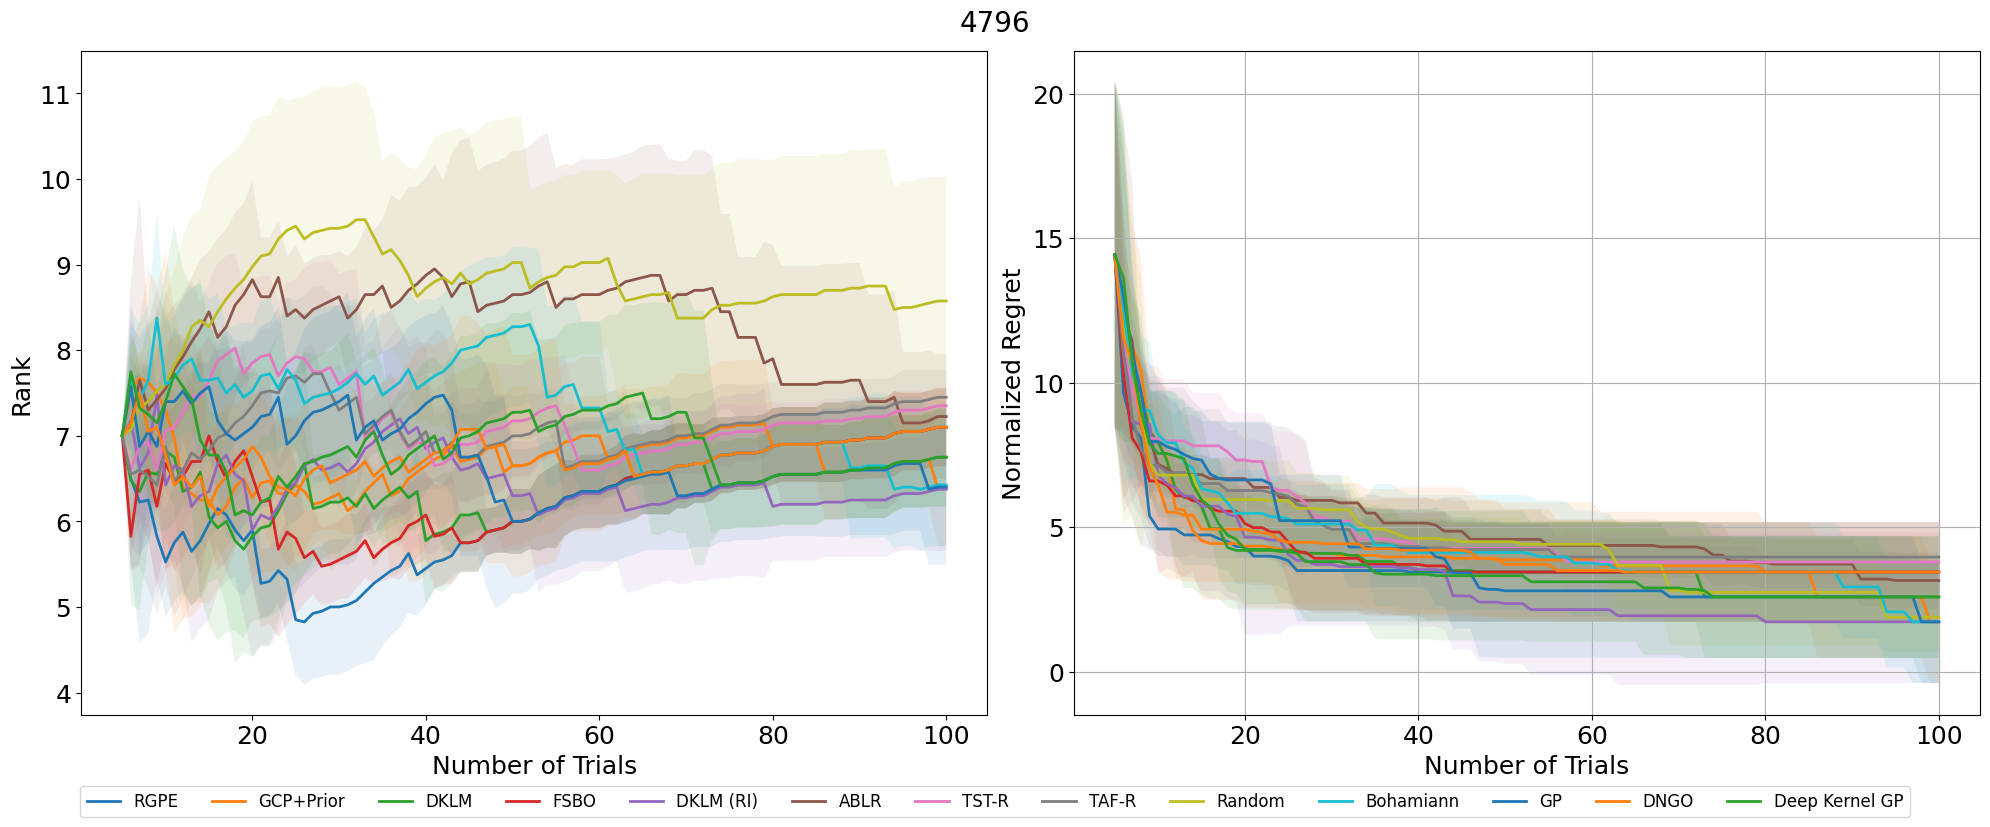

In [75]:
# plotting variables
offset = 5
axis_font = 18
title_font = 20
labelsize = 18
linewidth=2
legend_font=12

fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
x_values = range(offset, offset + search_space_results_rank_mean.shape[0])
subaxs  = axs[0]
for c in col_names:
    _ = subaxs.plot(x_values, search_space_results_rank_mean[c], label=c, linewidth=linewidth)
    _ = subaxs.fill_between(x_values, search_space_results_rank_mean[c] + search_space_results_rank_std[c],
                            search_space_results_rank_mean[c] - search_space_results_rank_std[c], alpha=0.1)
_ = subaxs.grid()
handles, labels = subaxs.get_legend_handles_labels()
subaxs.legend_ = None
_ = subaxs.tick_params(axis='x', labelsize=labelsize)
_ = subaxs.tick_params(axis='y', labelsize=labelsize)
_ = subaxs.grid()
_ = subaxs.set_xlabel("Number of Trials", fontsize=axis_font)
_ = subaxs.set_ylabel("Rank", fontsize=axis_font)

subaxs  = axs[1]
for c in col_names:
    _ = subaxs.plot(x_values, search_space_results_mean[c], linewidth=linewidth)
    _ = subaxs.fill_between(x_values, search_space_results_mean[c] + search_space_results_std[c],
                            search_space_results_mean[c] - search_space_results_std[c], alpha=0.1)
_ = subaxs.grid()
_ = subaxs.set_xlabel("Number of Trials", fontsize=axis_font)
_ = subaxs.set_ylabel("Normalized Regret", fontsize=axis_font)
_ = subaxs.tick_params(axis='x', labelsize=labelsize)
_ = subaxs.tick_params(axis='y', labelsize=labelsize)
_ = fig.legend(handles, labels,loc='lower center',bbox_to_anchor=(0.50, -0.04),ncol=len(col_names), fontsize=legend_font)
_ = fig.suptitle(search_space_id, fontsize=title_font)
_ = plt.tight_layout()

In [87]:
search_space_results_rank_mean.loc[[20, 45, 95]].rename(index={20:25, 45:50, 95:100}).transpose().sort_values(by=100, ascending=True)

,25,50,100
DKLM (RI),6.450,6.300,6.375
GCP+Prior,6.425,6.650,6.400
GP,7.000,6.000,6.400
Bohamiann,7.650,8.275,6.425
DKLM,6.450,6.000,6.750
Deep Kernel GP,6.525,7.275,6.750
RGPE,4.850,6.000,7.100
FSBO,5.800,6.000,7.100
DNGO,6.300,6.650,7.100
ABLR,8.475,8.650,7.225


In [88]:
search_space_results_mean.loc[[20, 45, 95]].rename(index={20:25, 45:50, 95:100}).transpose().sort_values(by=100, ascending=True)

,25,50,100
GCP+Prior,4.232443,3.871101,1.724283
DKLM (RI),4.064118,2.358086,1.724283
Bohamiann,5.288246,4.126059,1.724283
GP,5.226079,2.797692,1.724283
Random,5.912920,4.494702,1.884568
DKLM,4.196482,3.448566,2.586425
Deep Kernel GP,4.160055,3.322211,2.586425
ABLR,6.029462,4.580025,3.154625
RGPE,3.844491,3.448566,3.448566
FSBO,4.485473,3.448566,3.448566
